# Introduction to Exploratory Data Analysis with sci-analysis
---

This notebook is a companion to the corresponding talk at PyTexas 2019: **Introduction to Exploratory Data Analysis with the sci-analysis Python Package**.

### What is sci-analysis?

sci-analysis is an open-source Python package for quickly performing statistical data analysis. It is built on top of well known and established packages in the PyData stack, such as NumPy, SciPy, Pandas and Matplotlib.

### Why sci-analysis?

sci-analysis aims to make performing Exploratory Data Analysis (EDA) easier for newcomers and experienced data scientists alike by abstracting away the specific SciPy, NumPy, and Matplotlib commands. This is accomplished by using sci-analysis’s `analyze()` function.

### Features:

* Intuitive and easy to use.
* Automatically performs the appropriate analysis based on the input data.
* Reduces the need to write boilerplate code.
* Outputs a graph, summary stats, and appropriate hypothesis test results.
* Seamlessly handles missing values.
* Input values can be python lists, tuples, dictionaries, NumPy arrays, or pandas Series.

### Analysis Types:

* Distribution of continuous, numeric data.
* Distribution of categorical data.
* Bivariate and linear regression analysis of continuous, numeric data.
* Location testing of numeric data.

## The Exercise

The best way to learn sci-analysis and what it can do is with an example. For this exercise, we'll use the NOAA GSOD data to try to answer the question **"Which city has the best weather?"** Now, the table is 16 GB and "best weather" is fairly subjective, so let's provide a few constraints.

The compared cities will be:
* Austin
* Denver
* Las Vegas
* New York
* Seattle

The years to use from the dataset are:
* 2005 - 2009

The cities will be ranked based on a score of their weather. The score is determined by:

* (Average days with temp between 60-80 F + Average days with dew point 40-60 F) / 2 - Average number of bad weather days

### Setup

Before this notebook can be run, you'll need access to the dataset, which is a Google Cloud BigQuery table. First, create a Google account if you don't already have one. Next, you can access the dataset from the Web UI [here](https://console.cloud.google.com/bigquery?p=bigquery-public-data&d=samples&t=gsod&page=table).

From the Web UI, you can briefly explore the dataset. In order to query the table from the notebook, you will need to create a new Google Cloud [Project](https://medium.com/google-cloud/how-to-create-cloud-platform-projects-using-the-google-cloud-platform-console-e6f2cb95b467).

Once a new project has been created, follow [these instructions](https://cloud.google.com/bigquery/docs/reference/libraries#client-libraries-install-python) to generate a key file that the notebook and python will use to connect to and query the table.

Next, install sci-analysis and google-cloud-bigquery by running the commands below:

In [ ]:
!pip install sci-analysis

In [ ]:
!pip install google-cloud-bigquery

After installing sci-analysis and google-cloud-bigquery, we can import biquery, pandas and the sci-analysis `analyze()` function.

In [3]:
from google.cloud import bigquery
import pandas as pd

In [4]:
%matplotlib inline
from sci_analysis import analyze

Next, the bigquery client is initialized.

In [5]:
client = bigquery.Client()

NOAA official weather stations that collect all GSOD data can be identified by their Weather-Bureau-Army-Navy (WBAN) station number. A station from each city is selected from [this list](http://www.weathergraphics.com/identifiers/master-station.dat):
* 13958 - Austin Camp Mabry
* 03017 - CO Denver/Intl
* 24233 - Seattle-Tacoma/Intl
* 94728 - New York/Central Park
* 23169 - Las Vegas/McCarran Intl

Now, let's query the table:

In [6]:
df = client.query(
  "SELECT * FROM `bigquery-public-data.samples.gsod` " \
  "WHERE wban_number IN (13958, 03017, 24233, 94728, 23169) AND year IN (2005, 2006, 2007, 2008, 2009)"
).to_dataframe()

### Exploring the Data

Referring to the cities in the dataset by their station number will get confusing fast, so lets assign city names to each corresponding WBAN station number:

In [7]:
def set_city(station):
  if station == 13958:
    city = 'Austin'
  elif station == 3017:
    city = 'Denver'
  elif station == 24233:
    city = 'Seattle'
  elif station == 94728:
    city = 'New York'
  elif station == 23169:
    city = 'Las Vegas'
  else:
    city = 'Unknown'
  return city

In [8]:
df['city'] = df['wban_number'].apply(set_city)

When working with any new dataset, it's always a good idea to check how many rows are in the dataset, what columns are available, and what their data types are.

In [9]:
len(df)

9081

In [10]:
df.columns

Index(['station_number', 'wban_number', 'year', 'month', 'day', 'mean_temp',
       'num_mean_temp_samples', 'mean_dew_point', 'num_mean_dew_point_samples',
       'mean_sealevel_pressure', 'num_mean_sealevel_pressure_samples',
       'mean_station_pressure', 'num_mean_station_pressure_samples',
       'mean_visibility', 'num_mean_visibility_samples', 'mean_wind_speed',
       'num_mean_wind_speed_samples', 'max_sustained_wind_speed',
       'max_gust_wind_speed', 'max_temperature', 'max_temperature_explicit',
       'min_temperature', 'min_temperature_explicit', 'total_precipitation',
       'snow_depth', 'fog', 'rain', 'snow', 'hail', 'thunder', 'tornado',
       'city'],
      dtype='object')

In [11]:
df.dtypes

station_number                          int64
wban_number                             int64
year                                    int64
month                                   int64
day                                     int64
mean_temp                             float64
num_mean_temp_samples                   int64
mean_dew_point                        float64
num_mean_dew_point_samples              int64
mean_sealevel_pressure                float64
num_mean_sealevel_pressure_samples    float64
mean_station_pressure                 float64
num_mean_station_pressure_samples     float64
mean_visibility                       float64
num_mean_visibility_samples             int64
mean_wind_speed                       float64
num_mean_wind_speed_samples           float64
max_sustained_wind_speed              float64
max_gust_wind_speed                   float64
max_temperature                       float64
max_temperature_explicit                 bool
min_temperature                   

Let's also check to make sure there aren't any exact duplicate rows in the dataset which could potentially skew the results. If the number of rows in the dataset doesn't change after calling `drop_duplicates()`, then our dataset is exact duplicate free.

In [12]:
len(df.drop_duplicates())

9081

### Exploring the Data with sci-analysis

Since our analysis depends on how many measurements (data points) we have for each city, it's a good idea to check to make sure the counts are roughly even for each city. If one or more cities have significantly fewer measurements compared to other cities, it will be difficult to make a fair comparison between them, which could lead us to make the wrong conclusion.

Luckily, sci-analysis makes this simple. By using the `analyze()` function and passing in the *city* column from our dataset, we can see that each of the five cities has nearly 20% of the measurements in our dataset:

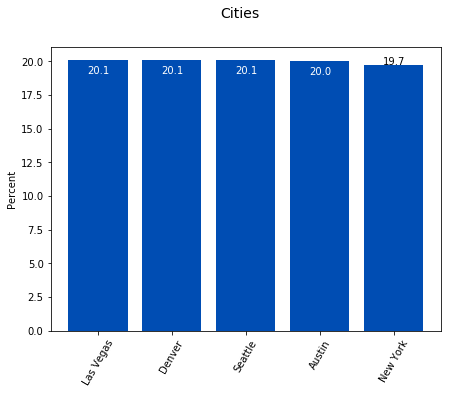



Overall Statistics
------------------

Total            =  9081
Number of Groups =  5


Statistics
----------

Rank          Frequency     Percent       Category      
--------------------------------------------------------
1             1825           20.0969      Las Vegas     
2             1824           20.0859      Denver        
3             1823           20.0749      Seattle       
4             1817           20.0088      Austin        
5             1792           19.7335      New York      


In [13]:
analyze(
    df['city'], 
    percent=True,
    vertical=False,
    title="Cities",
)

You can see that sci-analysis created a bar chart of each city by percent, as well as printed the number of measurements, number of groups, and the rank, frequency, and percent for each city.

Next, let's do the same thing for year and month to make sure the count for a particular year or month isn't significantly smaller than the others:

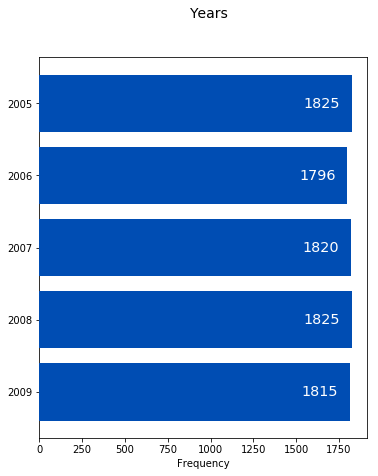



Overall Statistics
------------------

Total            =  9081
Number of Groups =  5


Statistics
----------

Rank          Frequency     Percent       Category      
--------------------------------------------------------
1             1825           20.0969      2005          
1             1825           20.0969      2008          
2             1820           20.0418      2007          
3             1815           19.9868      2009          
4             1796           19.7776      2006          


In [14]:
analyze(
    df['year'].astype(str), 
    order=['2005', '2006', '2007', '2008', '2009'],
    title="Years",
)

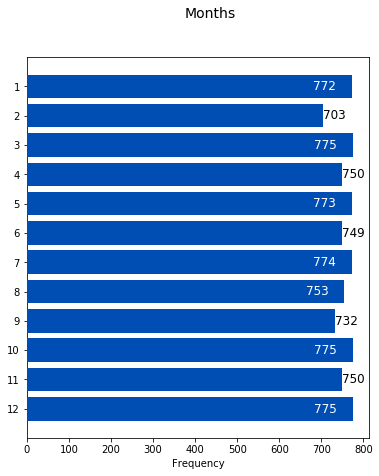



Overall Statistics
------------------

Total            =  9081
Number of Groups =  12


Statistics
----------

Rank          Frequency     Percent       Category      
--------------------------------------------------------
1             775            8.5343       10            
1             775            8.5343       12            
1             775            8.5343       3             
2             774            8.5233       7             
3             773            8.5123       5             
4             772            8.5013       1             
5             753            8.2920       8             
6             750            8.2590       11            
6             750            8.2590       4             
7             749            8.2480       6             
8             732            8.0608       9             
9             703            7.7414       2             


In [15]:
analyze(
    df['month'].astype(str), 
    order=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'],
    title='Months',
)

Since one of the criteria for determining best weather is temperature, let's examine the distribution of the temperature measurements. Our dataset contains two measurements, mean_temp and max_temperature.

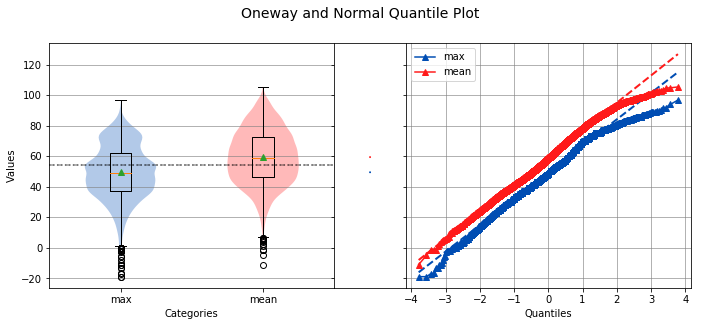



Overall Statistics
------------------

Number of Groups =  2
Total            =  18162
Grand Mean       =  54.4751
Pooled Std Dev   =  17.6159
Grand Median     =  54.0000


Group Statistics
----------------

n             Mean          Std Dev       Min           Median        Max           Group         
--------------------------------------------------------------------------------------------------
9081           49.5082       17.3755      -18.9000       48.9000       96.8000      max           
9081           59.4420       17.8530      -11.0000       59.1000       105.4000     mean          


Mann Whitney U Test
-------------------

alpha   =  0.0500
u value =  53642607.5000
p value =  2.0000

H0: Locations are matched



In [19]:
analyze({'mean': df['mean_temp'], 'max': df['max_temperature']})

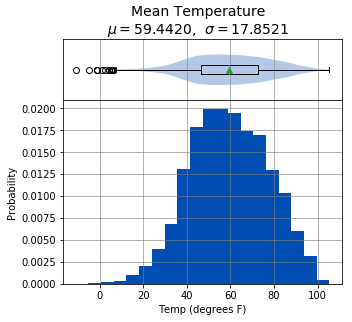



Statistics
----------

n         =  9081
Mean      =  59.4420
Std Dev   =  17.8521
Std Error =  0.1873
Skewness  = -0.0574
Kurtosis  = -0.4261
Maximum   =  105.4000
75%       =  72.7000
50%       =  59.1000
25%       =  46.4000
Minimum   = -11.0000
IQR       =  26.3000
Range     =  116.4000


Shapiro-Wilk test for normality
-------------------------------

alpha   =  0.0500
W value =  0.9947
p value =  0.0000

HA: Data is not normally distributed



In [20]:
analyze(
    df['mean_temp'], 
    title="Mean Temperature", 
    name="Temp (degrees F)",
)

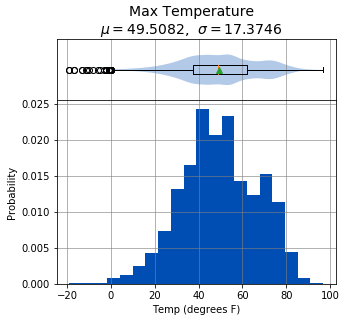



Statistics
----------

n         =  9081
Mean      =  49.5082
Std Dev   =  17.3746
Std Error =  0.1823
Skewness  = -0.1399
Kurtosis  = -0.2608
Maximum   =  96.8000
75%       =  62.1000
50%       =  48.9000
25%       =  37.4000
Minimum   = -18.9000
IQR       =  24.7000
Range     =  115.7000


Shapiro-Wilk test for normality
-------------------------------

alpha   =  0.0500
W value =  0.9920
p value =  0.0000

HA: Data is not normally distributed



In [47]:
analyze(
    df['max_temperature'], 
    title="Max Temperature", 
    name="Temp (degrees F)",
)

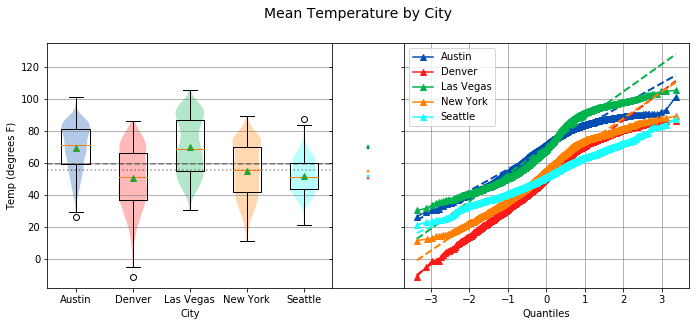



Overall Statistics
------------------

Number of Groups =  5
Total            =  9081
Grand Mean       =  59.4315
Pooled Std Dev   =  15.6006
Grand Median     =  55.4000


Group Statistics
----------------

n             Mean          Std Dev       Min           Median        Max           Group         
--------------------------------------------------------------------------------------------------
1817           69.5338       13.7406       26.5000       71.4000       101.3000     Austin        
1824           50.6471       18.1530      -11.0000       51.0000       86.3000      Denver        
1825           70.3106       17.5165       30.4000       68.5000       105.4000     Las Vegas     
1792           54.8196       16.7329       11.5000       55.4000       89.2000      New York      
1823           51.8465       10.5860       21.2000       51.2000       87.7000      Seattle       


Levene Test
-----------

alpha   =  0.0500
W value =  210.2088
p value =  0.0000

HA: Variances 

In [22]:
analyze(
    df['mean_temp'], 
    groups=df['city'], 
    title="Mean Temperature by City",
    name="Temp (degrees F)",
    categories="City",
)

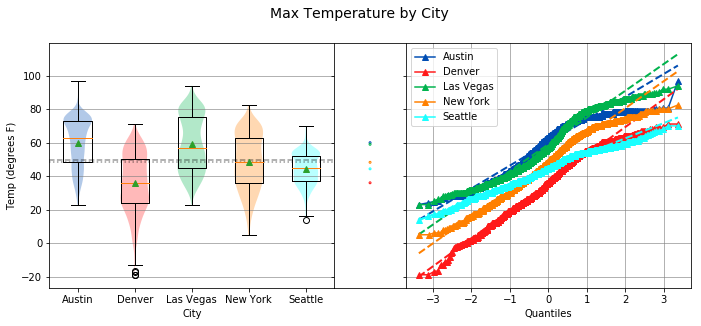



Overall Statistics
------------------

Number of Groups =  5
Total            =  9081
Grand Mean       =  49.5102
Pooled Std Dev   =  14.8271
Grand Median     =  48.2000


Group Statistics
----------------

n             Mean          Std Dev       Min           Median        Max           Group         
--------------------------------------------------------------------------------------------------
1817           59.9664       14.1633       23.0000       63.0000       96.8000      Austin        
1824           36.0190       16.7703      -18.9000       36.0000       71.1000      Denver        
1825           58.9834       16.3447       23.0000       57.0000       93.9000      Las Vegas     
1792           48.2426       16.3234       5.0000        48.2000       82.4000      New York      
1823           44.3396       9.1875        14.0000       44.6000       70.0000      Seattle       


Levene Test
-----------

alpha   =  0.0500
W value =  213.0663
p value =  0.0000

HA: Variances 

In [21]:
analyze(
    df['max_temperature'], 
    groups=df['city'], 
    title="Max Temperature by City",
    name="Temp (degrees F)",
    categories="City",
)

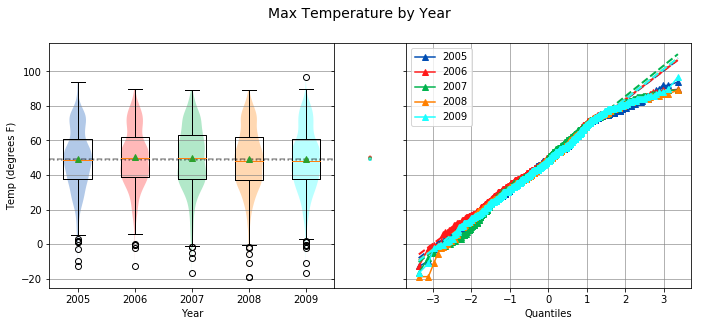



Overall Statistics
------------------

Number of Groups =  5
Total            =  9081
Grand Mean       =  49.5103
Pooled Std Dev   =  17.3735
Grand Median     =  48.9000


Group Statistics
----------------

n             Mean          Std Dev       Min           Median        Max           Group         
--------------------------------------------------------------------------------------------------
1825           49.3040       17.1345      -13.0000       48.9000       93.9000      2005          
1796           50.2786       16.7936      -13.0000       50.0000       89.6000      2006          
1820           49.7616       17.9735      -16.6000       50.0000       89.1000      2007          
1825           49.1387       17.4467      -18.9000       48.2000       89.1000      2008          
1815           49.0688       17.4900      -17.0000       48.2000       96.8000      2009          


Levene Test
-----------

alpha   =  0.0500
W value =  3.2357
p value =  0.0116

HA: Variances ar

In [49]:
analyze(
    df['max_temperature'], 
    groups=df['year'].astype(str),
    title="Max Temperature by Year",
    name="Temp (degrees F)",
    categories="Year",
)

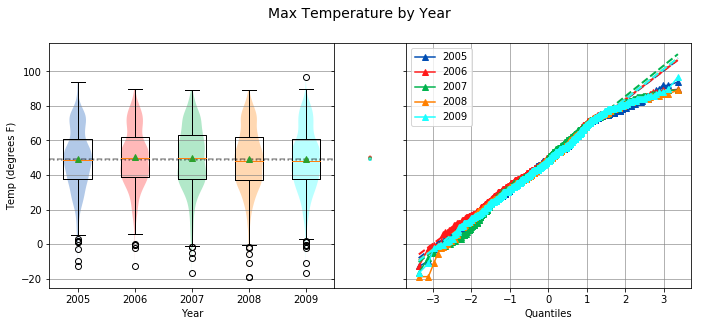



Overall Statistics
------------------

Number of Groups =  5
Total            =  9081
Grand Mean       =  49.5103
Pooled Std Dev   =  17.3735
Grand Median     =  48.9000


Group Statistics
----------------

n             Mean          Std Dev       Min           Median        Max           Group         
--------------------------------------------------------------------------------------------------
1825           49.3040       17.1345      -13.0000       48.9000       93.9000      2005          
1796           50.2786       16.7936      -13.0000       50.0000       89.6000      2006          
1820           49.7616       17.9735      -16.6000       50.0000       89.1000      2007          
1825           49.1387       17.4467      -18.9000       48.2000       89.1000      2008          
1815           49.0688       17.4900      -17.0000       48.2000       96.8000      2009          


Levene Test
-----------

alpha   =  0.0010
W value =  3.2357
p value =  0.0116

H0: Variances ar

In [48]:
analyze(
    df['max_temperature'], 
    groups=df['year'].astype(str),
    title="Max Temperature by Year",
    name="Temp (degrees F)",
    categories="Year",
    alpha=0.001,
)

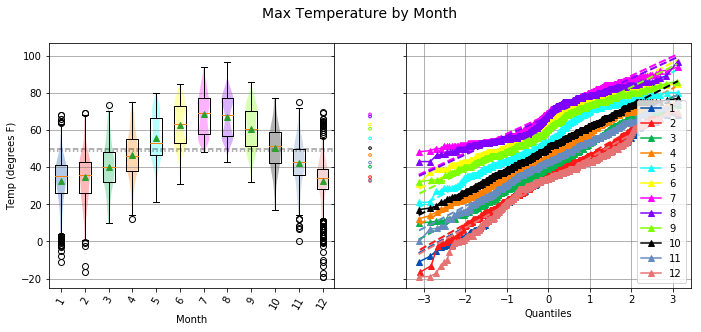



Overall Statistics
------------------

Number of Groups =  12
Total            =  9081
Grand Mean       =  49.4944
Pooled Std Dev   =  11.8358
Grand Median     =  48.5500


Group Statistics
----------------

n             Mean          Std Dev       Min           Median        Max           Group         
--------------------------------------------------------------------------------------------------
 772.0000      32.7984       12.6435      -11.0000       35.1000       68.0000       1.0000       
 703.0000      34.6070       12.6493      -16.6000       35.6000       69.1000       2.0000       
 775.0000      40.2133       12.5373       10.0000       39.9000       73.4000       3.0000       
 750.0000      46.5020       11.9696       12.2000       46.0000       75.2000       4.0000       
 773.0000      55.5176       12.0295       21.0000       53.1000       80.1000       5.0000       
 749.0000      62.9073       11.3326       30.9000       63.0000       84.9000       6.0000      

In [44]:
analyze(
    df['max_temperature'], 
    groups=df['month'],
    title="Max Temperature by Month",
    name="Temp (degrees F)",
    categories="Month",
)

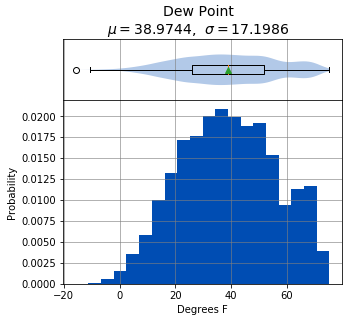



Statistics
----------

n         =  9081
Mean      =  38.9744
Std Dev   =  17.1986
Std Error =  0.1805
Skewness  = -0.0295
Kurtosis  = -0.7085
Maximum   =  75.2000
75%       =  51.7000
50%       =  38.7000
25%       =  26.0000
Minimum   = -15.7000
IQR       =  25.7000
Range     =  90.9000


Shapiro-Wilk test for normality
-------------------------------

alpha   =  0.0500
W value =  0.9874
p value =  0.0000

HA: Data is not normally distributed



In [18]:
analyze(
    df['mean_dew_point'], 
    title="Dew Point", 
    name="Degrees F",
)

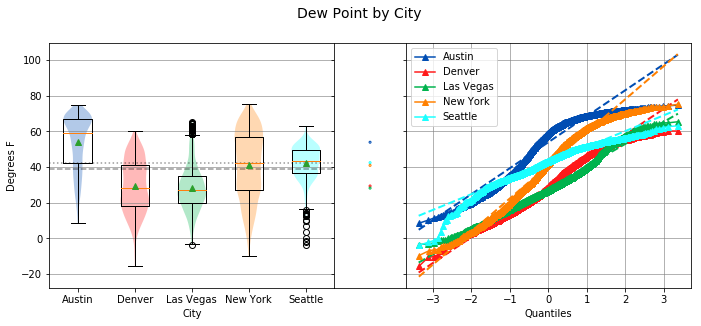



Overall Statistics
------------------

Number of Groups =  5
Total            =  9081
Grand Mean       =  38.9943
Pooled Std Dev   =  14.3617
Grand Median     =  42.3000


Group Statistics
----------------

n             Mean          Std Dev       Min           Median        Max           Group         
--------------------------------------------------------------------------------------------------
1817           53.9256       15.2793       8.5000        58.9000       74.7000      Austin        
1824           29.4137       14.5178      -15.7000       28.5500       60.2000      Denver        
1825           28.2031       12.4701      -3.4000        27.0000       65.4000      Las Vegas     
1792           40.9393       18.7991      -9.6000        42.3000       75.2000      New York      
1823           42.4900       8.9893       -3.9000        43.3000       63.1000      Seattle       


Levene Test
-----------

alpha   =  0.0500
W value =  277.4953
p value =  0.0000

HA: Variances 

In [19]:
analyze(
    df['mean_dew_point'], 
    groups=df['city'],
    title="Dew Point by City",
    name="Degrees F",
    categories="City",
)

In [20]:
fields = [
        'mean_temp',
        'mean_dew_point',
        'mean_sealevel_pressure',
        'mean_visibility',
        'mean_wind_speed,',
        'max_sustained_wind_speed',
        'max_gust_wind_speed',
        'max_temperature',
        'max_temperature_explicit',
        'min_temperature',
        'min_temperature_explicit',
        'total_precipitation',
        'snow_depth',
    ]
corr = df.corr()
corr = corr.filter(fields).filter(fields, axis=0)
corr[((corr > 0.5) | (corr < -0.5)) & (corr != 1.0)].dropna(how='all').dropna(how='all', axis=1)

,mean_temp,mean_dew_point,max_sustained_wind_speed,max_gust_wind_speed,max_temperature,total_precipitation,snow_depth
mean_temp,NaN,0.617921,NaN,NaN,0.964147,NaN,NaN
mean_dew_point,0.617921,NaN,NaN,NaN,0.695708,NaN,NaN
max_sustained_wind_speed,NaN,NaN,NaN,0.871199,NaN,NaN,NaN
max_gust_wind_speed,NaN,NaN,0.871199,NaN,NaN,NaN,NaN
max_temperature,0.964147,0.695708,NaN,NaN,NaN,NaN,NaN
total_precipitation,NaN,NaN,NaN,NaN,NaN,NaN,0.506278
snow_depth,NaN,NaN,NaN,NaN,NaN,0.506278,NaN


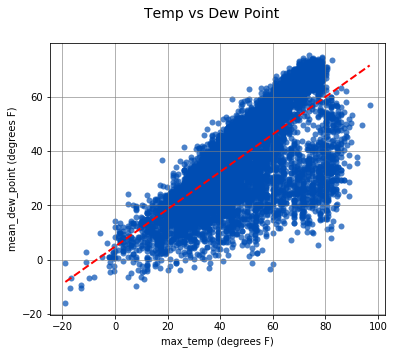



Linear Regression
-----------------

n         =  9081
Slope     =  0.6887
Intercept =  4.8800
r         =  0.6957
r^2       =  0.4840
Std Err   =  0.0075
p value   =  0.0000



Spearman Correlation Coefficient
--------------------------------

alpha   =  0.0500
r value =  0.6901
p value =  0.0000

HA: There is a significant relationship between predictor and response



In [51]:
analyze(
    df['max_temperature'], 
    df['mean_dew_point'],
    xname='max_temp (degrees F)',
    yname='mean_dew_point (degrees F)',
    title='Temp vs Dew Point',
)

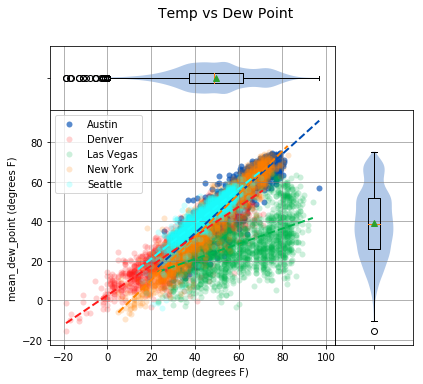



Linear Regression
-----------------

n             Slope         Intercept     r^2           Std Err       p value       Group         
--------------------------------------------------------------------------------------------------
1817           1.0042       -6.2920        0.8665        0.0093        0.0000       Austin        
1824           0.7470        2.5090        0.7445        0.0103        0.0000       Denver        
1825           0.3853        5.4765        0.2550        0.0154        0.0000       Las Vegas     
1792           1.0891       -11.6015       0.8943        0.0089        0.0000       New York      
1823           0.8848        3.2585        0.8178        0.0098        0.0000       Seattle       


Spearman Correlation Coefficient
--------------------------------

n             r value       p value       Group         
--------------------------------------------------------
1817           0.9225        0.0000       Austin        
1824           0.8650       

In [22]:
analyze(
    df['max_temperature'], 
    df['mean_dew_point'],
    groups=df['city'],
    xname='max_temp (degrees F)',
    yname='mean_dew_point (degrees F)',
    title='Temp vs Dew Point',
    highlight=['Austin'],
)

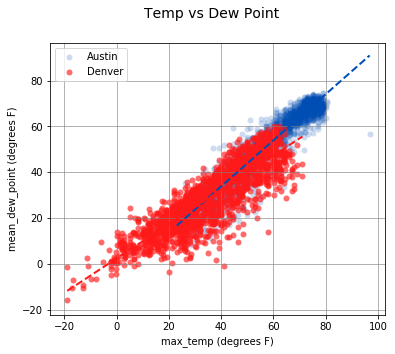



Linear Regression
-----------------

n             Slope         Intercept     r^2           Std Err       p value       Group         
--------------------------------------------------------------------------------------------------
1817           1.0042       -6.2920        0.8665        0.0093        0.0000       Austin        
1824           0.7470        2.5090        0.7445        0.0103        0.0000       Denver        


Spearman Correlation Coefficient
--------------------------------

n             r value       p value       Group         
--------------------------------------------------------
1817           0.9225        0.0000       Austin        
1824           0.8650        0.0000       Denver        


In [23]:
city = df.query("city in ['Austin', 'Denver']")
analyze(
    city['max_temperature'], 
    city['mean_dew_point'],
    xname='max_temp (degrees F)',
    yname='mean_dew_point (degrees F)',
    title='Temp vs Dew Point',
    boxplot_borders=False,
    groups=city['city'],
    highlight=['Denver'],
)

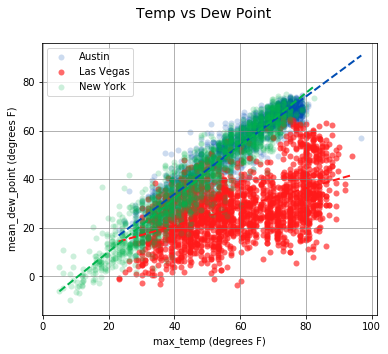



Linear Regression
-----------------

n             Slope         Intercept     r^2           Std Err       p value       Group         
--------------------------------------------------------------------------------------------------
1817           1.0042       -6.2920        0.8665        0.0093        0.0000       Austin        
1825           0.3853        5.4765        0.2550        0.0154        0.0000       Las Vegas     
1792           1.0891       -11.6015       0.8943        0.0089        0.0000       New York      


Spearman Correlation Coefficient
--------------------------------

n             r value       p value       Group         
--------------------------------------------------------
1817           0.9225        0.0000       Austin        
1825           0.4778        0.0000       Las Vegas     
1792           0.9466        0.0000       New York      


In [24]:
city = df.query("city in ['Austin', 'New York', 'Las Vegas']")
analyze(
    city['max_temperature'], 
    city['mean_dew_point'],
    xname='max_temp (degrees F)',
    yname='mean_dew_point (degrees F)',
    title='Temp vs Dew Point',
    boxplot_borders=False,
    groups=city['city'],
    highlight=['Las Vegas'],
)

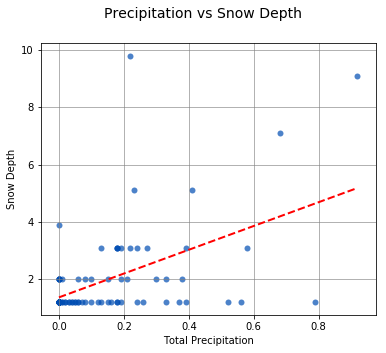



Linear Regression
-----------------

n         =  83
Slope     =  4.1494
Intercept =  1.3665
r         =  0.5063
r^2       =  0.2563
Std Err   =  0.7853
p value   =  0.0000



Spearman Correlation Coefficient
--------------------------------

alpha   =  0.0500
r value =  0.4165
p value =  0.0001

HA: There is a significant relationship between predictor and response



In [25]:
analyze(
    df['total_precipitation'], 
    df['snow_depth'],
    xname='Total Precipitation',
    yname='Snow Depth',
    title='Precipitation vs Snow Depth'
)

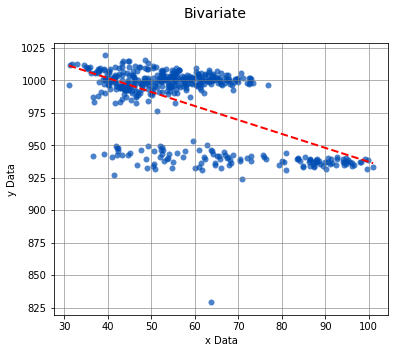



Linear Regression
-----------------

n         =  456
Slope     = -1.0761
Intercept =  1044.9137
r         = -0.5733
r^2       =  0.3287
Std Err   =  0.0722
p value   =  0.0000



Spearman Correlation Coefficient
--------------------------------

alpha   =  0.0500
r value = -0.4090
p value =  0.0000

HA: There is a significant relationship between predictor and response



In [56]:
analyze(
    df['mean_temp'], 
    df['mean_station_pressure'],
)

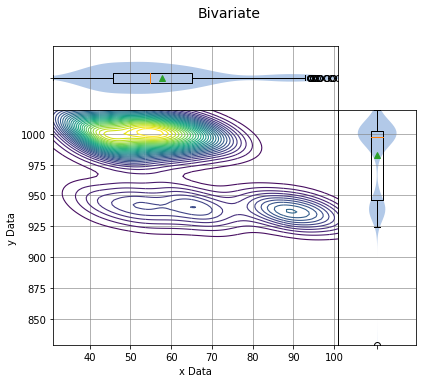



Linear Regression
-----------------

n         =  456
Slope     = -1.0761
Intercept =  1044.9137
r         = -0.5733
r^2       =  0.3287
Std Err   =  0.0722
p value   =  0.0000



Spearman Correlation Coefficient
--------------------------------

alpha   =  0.0500
r value = -0.4090
p value =  0.0000

HA: There is a significant relationship between predictor and response



In [55]:
analyze(
    df['mean_temp'], 
    df['mean_station_pressure'], 
    fit=False,
    contours=True,
    points=False,
    boxplot_borders=True,
)

In [27]:
df.filter([
    'total_precipitation', 
    'snow_depth',
    'fog',
    'rain',
    'snow',
    'hail',
    'thunder',
    'tornado',
]).dtypes

total_precipitation    float64
snow_depth             float64
fog                       bool
rain                      bool
snow                      bool
hail                      bool
thunder                   bool
tornado                   bool
dtype: object

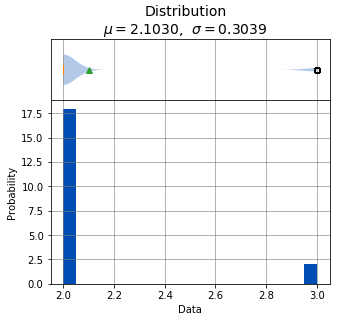



Statistics
----------

n         =  9081
Mean      =  2.1030
Std Dev   =  0.3039
Std Error =  0.0032
Skewness  =  2.6129
Kurtosis  =  4.8271
Maximum   =  3.0000
75%       =  2.0000
50%       =  2.0000
25%       =  2.0000
Minimum   =  2.0000
IQR       =  0.0000
Range     =  1.0000


Shapiro-Wilk test for normality
-------------------------------

alpha   =  0.0500
W value =  0.3479
p value =  0.0000

HA: Data is not normally distributed



In [30]:
analyze(df['fog'])

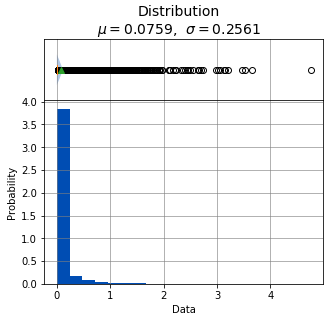



Statistics
----------

n         =  8998
Mean      =  0.0759
Std Dev   =  0.2561
Std Error =  0.0027
Skewness  =  6.4463
Kurtosis  =  59.0255
Maximum   =  4.7500
75%       =  0.0100
50%       =  0.0000
25%       =  0.0000
Minimum   =  0.0000
IQR       =  0.0100
Range     =  4.7500


Shapiro-Wilk test for normality
-------------------------------

alpha   =  0.0500
W value =  0.3273
p value =  0.0000

HA: Data is not normally distributed



In [64]:
analyze(df['total_precipitation'])

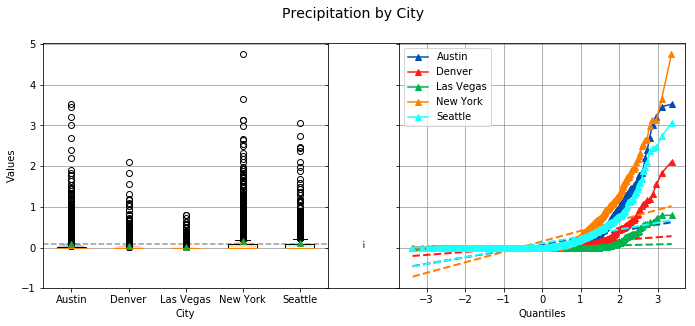



Overall Statistics
------------------

Number of Groups =  5
Total            =  8998
Grand Mean       =  0.0762
Pooled Std Dev   =  0.2512
Grand Median     =  0.0000


Group Statistics
----------------

n             Mean          Std Dev       Min           Median        Max           Group         
--------------------------------------------------------------------------------------------------
1795           0.0810        0.2893        0.0000        0.0000        3.5200       Austin        
1792           0.0360        0.1368        0.0000        0.0000        2.1100       Denver        
1819           0.0093        0.0582        0.0000        0.0000        0.7900       Las Vegas     
1781           0.1512        0.3848        0.0000        0.0000        4.7500       New York      
1811           0.1034        0.2511        0.0000        0.0000        3.0600       Seattle       


Levene Test
-----------

alpha   =  0.0500
W value =  88.7869
p value =  0.0000

HA: Variances are 

In [34]:
analyze(
    df['total_precipitation'], 
    groups=df['city'],
    title='Precipitation by City',
    categories='City',
)

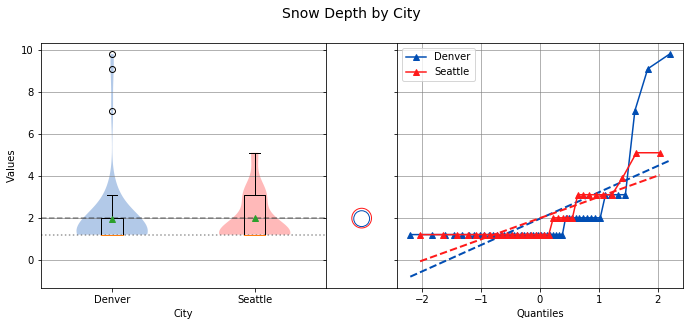



Overall Statistics
------------------

Number of Groups =  2
Total            =  83
Grand Mean       =  1.9724
Pooled Std Dev   =  1.5924
Grand Median     =  1.2000


Group Statistics
----------------

n             Mean          Std Dev       Min           Median        Max           Group         
--------------------------------------------------------------------------------------------------
50             1.9600        1.8247        1.2000        1.2000        9.8000       Denver        
33             1.9848        1.1489        1.2000        1.2000        5.1000       Seattle       


Mann Whitney U Test
-------------------

alpha   =  0.0500
u value =  735.5000
p value =  0.3378

H0: Locations are matched



In [35]:
analyze(
    df['snow_depth'], 
    groups=df['city'],
    title='Snow Depth by City',
    categories='City',
)

In [36]:
def set_good_weather(temp):
  if 60.0 <= temp <= 80.0:
    return True
  else:
    return False

In [37]:
def set_comfortable(dew_point):
  if 40.0 <= dew_point <= 60:
    return True
  else:
    return False

In [38]:
def bad_weather(data):
  return True if any(data) else False

In [39]:
df['fog_present'] = df['fog'] == 3
df['good_weather'] = df['max_temperature'].apply(set_good_weather)
df['comfortable'] = df['mean_dew_point'].apply(set_comfortable)
df['bad_weather'] = df[['rain', 'snow', 'hail', 'thunder', 'tornado', 'fog_present']].apply(bad_weather, axis=1)

In [66]:
summary = (
  df
  .filter(['year', 'city', 'good_weather', 'comfortable', 'bad_weather'])
  .groupby(['city', 'year'])
  .sum()
  .groupby('city')
  .mean()
)
summary['score'] = (summary['good_weather'] + summary['comfortable']) / 2 - summary['bad_weather']
summary.sort_values('score', ascending=False)

,good_weather,comfortable,bad_weather,score
city,,,,
Austin,205.4,109.6,36.6,120.9
Las Vegas,115.2,53.4,4.8,79.5
New York,107.4,125.6,46.4,70.1
Seattle,7.4,227.2,54.8,62.5
Denver,30.0,101.0,44.4,21.1
